# Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistrated functional images with FWHM set to 4mm and 8mm
4. Artifact Detection in functional images (to detect outlier volumes)

## Imports

First, let's import all modules we later will be needing.

In [4]:
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [12]:
experiment_dir = '/data/ds000105/'
output_dir = '/output/ds000105/'
working_dir = '/home/neuro/nipype_tutorial/notebooks/'

# list of subject identifiers
subject_list = ['sub-01']

# list of session identifiers
task_list = ['objectviewing']

# TR of functional images
with open('/data/ds000105/task-objectviewing_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [13]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

## Coregistration Workflow

Initiate a workflow that coregistrates the functional images to the anatomical image (according to FSL's FEAT pipeline).

In [14]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [15]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('{subject_id}',  'ses-test', 'anat', '{subject_id}_ses-test_T1w.nii.gz')
func_file = opj('{subject_id}', 'ses-test', 'func',
                '{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000114'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [18]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

171202-15:41:22,764 workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/notebooks/preproc/graph.dot.png (graph2use=colored, simple_form=True).


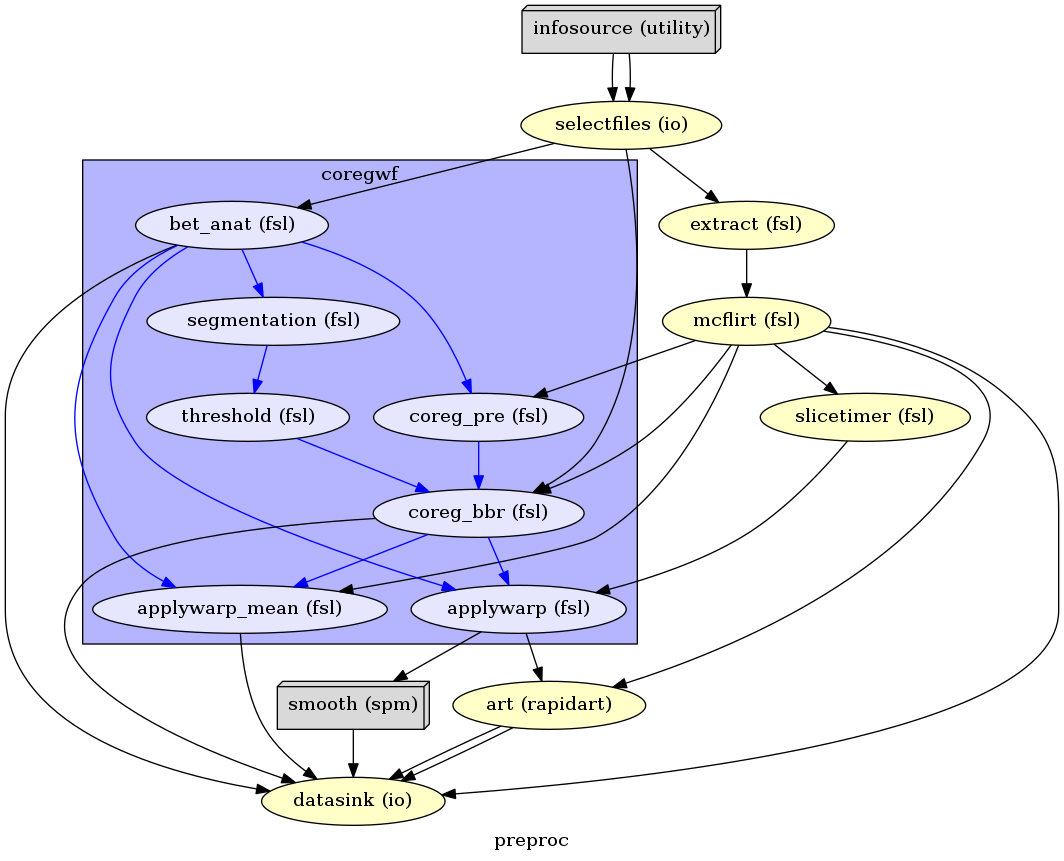

In [19]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

171202-15:41:51,849 workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/notebooks/preproc/graph.dot.png (graph2use=flat, simple_form=True).


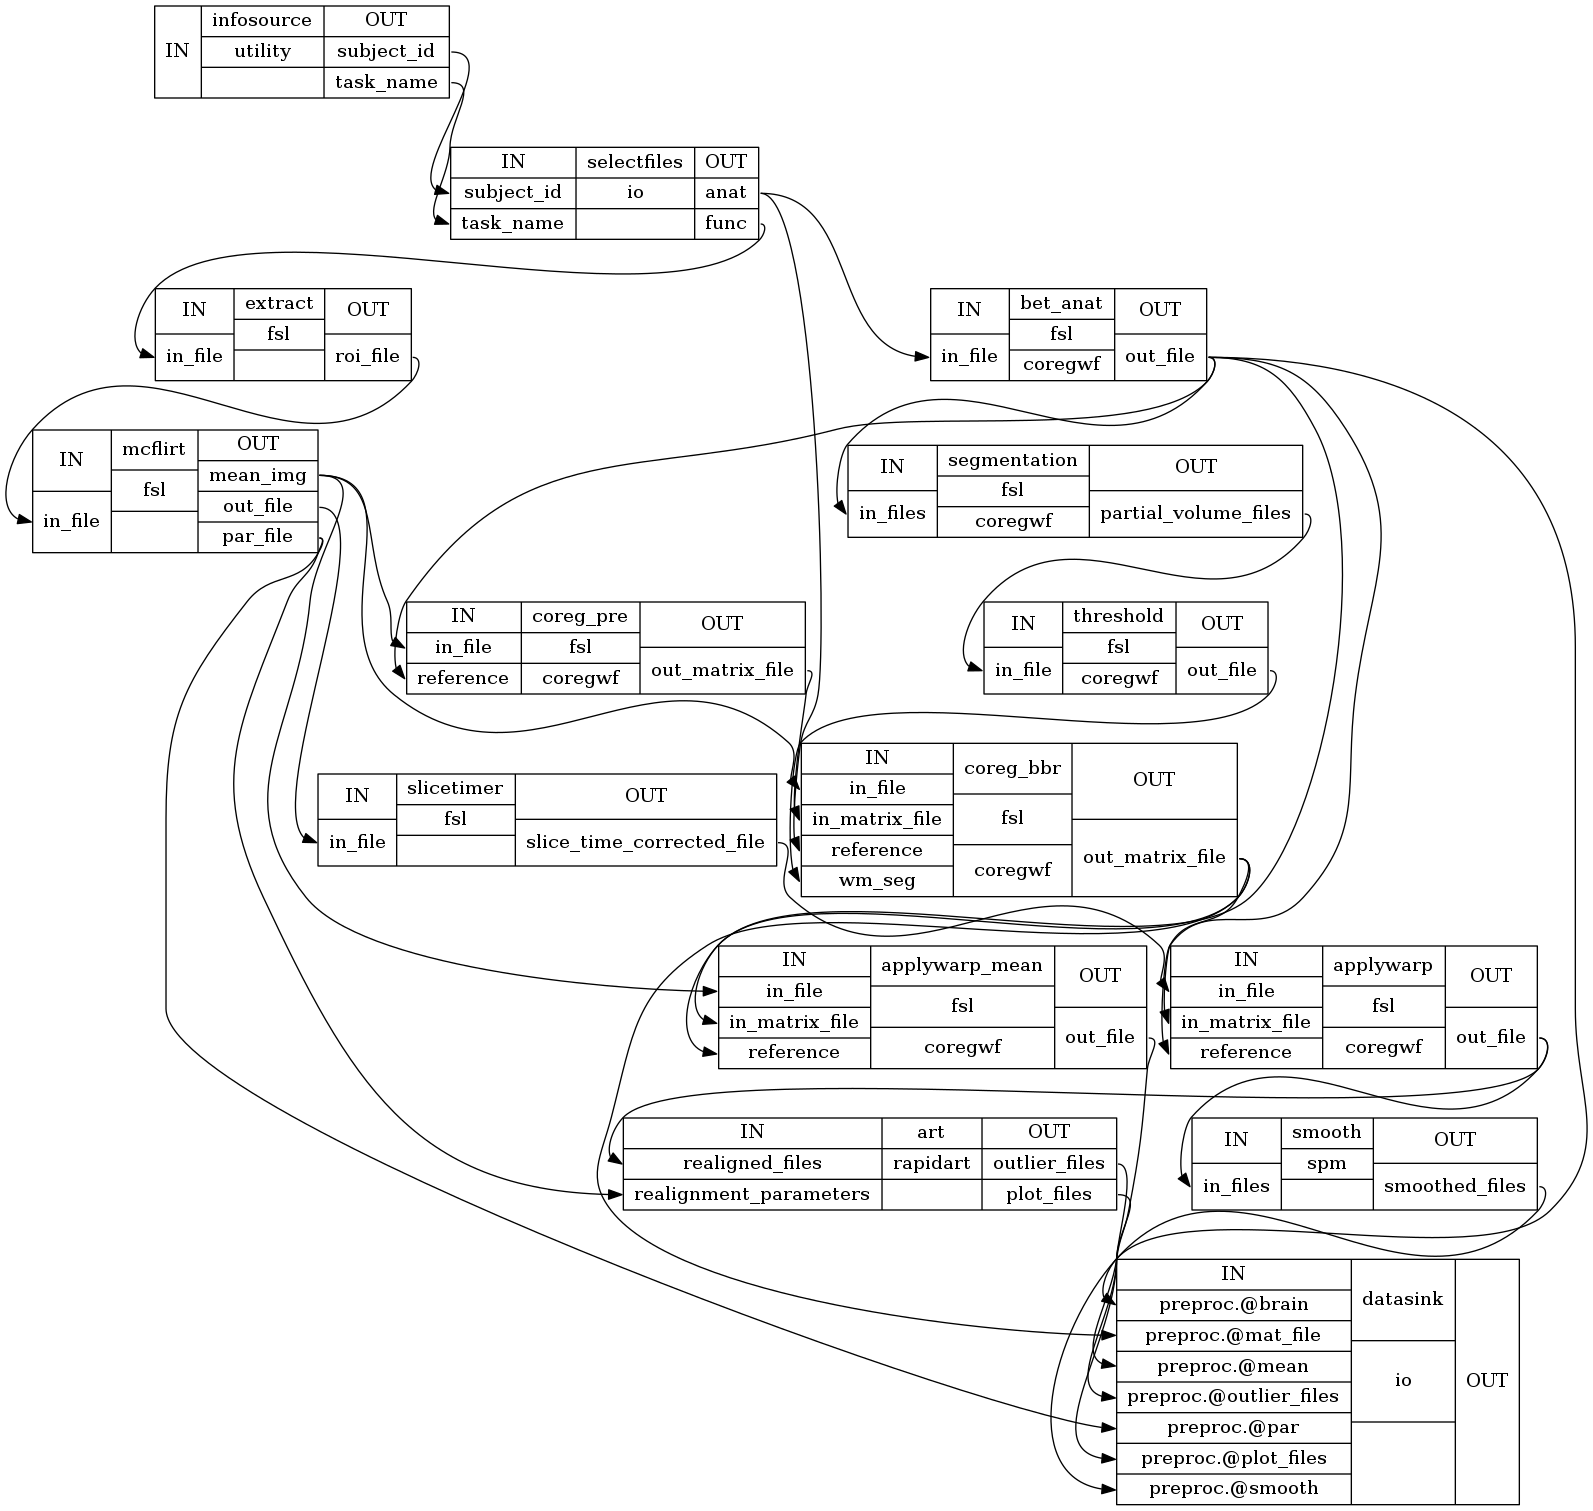

In [20]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [21]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

171202-15:42:31,636 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
171202-15:42:31,723 workflow INFO:
	 Running in parallel.
171202-15:42:31,729 workflow INFO:
	 Currently running 0 tasks, and 1 jobs ready. Free memory (GB): 5.14/5.14, Free processors: 4/4
171202-15:42:31,738 workflow INFO:
	 Executing node preproc.selectfiles in dir: /home/neuro/nipype_tutorial/notebooks/preproc/_subject_id_sub-01_task_name_objectviewing/selectfiles
171202-15:42:31,750 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.io.SelectFiles").
171202-15:42:33,738 workflow ERROR:
	 Node selectfiles.b0 failed to run on host 3ac6c1ed5564.
171202-15:42:33,743 workflow ERROR:
	 Saving crash info to /home/neuro/nipype_tutorial/notebooks/crash-20171202-154233-neuro-selectfiles.b0-386d1922-37a5-4792-ac64-6761ce0979bc.pklz
Traceback (most recent call last):
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 51, in run_node


RuntimeError: Workflow did not execute cleanly. Check log for details

# 1st-level Analysis

In this example we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

## Imports

First, we need to import all modules we later want to use.

In [49]:
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [51]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts (seven T-contrasts and two F-contrasts):

In [52]:
# Condition names
condition_names = ['scissors', 'face', 'cat', 'shoe', 'house', 'scrambledpix', 'bottle', 'chair']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/8., 1/8., 1/8., 1/8., 1/8., 1/8., 1/8., 1/8.]]
# cont02 = ['face',         'T', condition_names, [1, 0, 0]]
# cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
# cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
# cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
# cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
# cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

# cont08 = ['activation',     'F', [cont02, cont03, cont04]]
# cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01]

## Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [53]:
!cat /data/ds000105/dataset_description.json

{
    "BIDSVersion": "1.0.0",
    "License": "This dataset is made available under the Public Domain Dedication and License \nv1.0, whose full text can be found at \nhttp://www.opendatacommons.org/licenses/pddl/1.0/. \nWe hope that all users will follow the ODC Attribution/Share-Alike \nCommunity Norms (http://www.opendatacommons.org/norms/odc-by-sa/); \nin particular, while not legally required, we hope that all users \nof the data will acknowledge the OpenfMRI project and NSF Grant \nOCI-1131441 (R. Poldrack, PI) in any publications.",
    "Name": "Visual object recognition",
    "Authors": ["Haxby, J.V.", "Gobbini, M.I.", "Furey, M.L.", "Ishai, A.", "Schouten, J.L.", "Pietrini, P."],
    "ReferencesAndLinks": "Haxby, J.V., Gobbini, M.I., Furey, M.L., Ishai, A., Schouten, J.L., Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. Science, 293(5539):2425-30\n\nHanson, S.J., Matsuka, T., Haxby, J.V. (2004). Combinatorial code

We can also create a data frame using pandas library.

In [54]:
import pandas as pd
trialinfo = pd.read_table('/data/ds000105/sub-1/func/sub-1_task-objectviewing_run-01_events.tsv')
trialinfo

,onset,duration,trial_type
0,12.0,0.5,scissors
1,14.0,0.5,scissors
2,16.0,0.5,scissors
3,18.0,0.5,scissors
4,20.0,0.5,scissors
5,22.0,0.5,scissors
6,24.0,0.5,scissors
7,26.0,0.5,scissors
8,28.0,0.5,scissors
9,30.0,0.5,scissors


And finally we need to separate the onsets of the three conditions, i.e. group by ``trial_type``. This can be done as follows:

In [40]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('bottle',     onset  duration trial_type
72  228.0       0.5     bottle
73  230.0       0.5     bottle
74  232.0       0.5     bottle
75  234.0       0.5     bottle
76  236.0       0.5     bottle
77  238.0       0.5     bottle
78  240.0       0.5     bottle
79  242.0       0.5     bottle
80  244.0       0.5     bottle
81  246.0       0.5     bottle
82  248.0       0.5     bottle
83  250.0       0.5     bottle)

('cat',     onset  duration trial_type
24   84.0       0.5        cat
25   86.0       0.5        cat
26   88.0       0.5        cat
27   90.0       0.5        cat
28   92.0       0.5        cat
29   94.0       0.5        cat
30   96.0       0.5        cat
31   98.0       0.5        cat
32  100.0       0.5        cat
33  102.0       0.5        cat
34  104.0       0.5        cat
35  106.0       0.5        cat)

('chair',     onset  duration trial_type
84  264.0       0.5      chair
85  266.0       0.5      chair
86  268.0       0.5      chair
87  270.0       0.5      chair
88  27

Now, let us incorporate all this in the helper function ``subjectinfo``.

In [41]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/data/ds000105/sub-1/func/sub-1_task-objectviewing_run-01_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [43]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}_s{subject_id}_ses-test_task-{task_id}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                             '{subject_id}_ses-test_task-{task_id}_bold.par'),
             'outliers': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}', 
                             'art.{subject_id}_ses-test_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'objectviewing'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [44]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

171201-23:59:54,887 workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/notebooks/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).


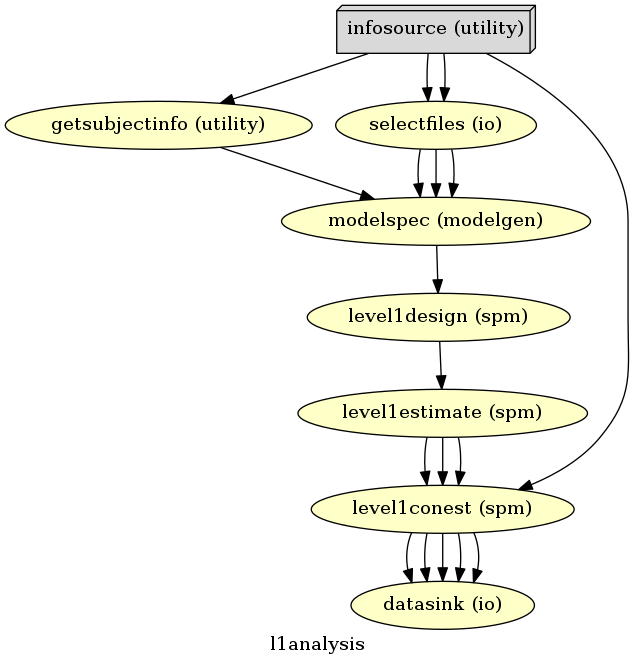

In [45]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [46]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

# !nipypecli crash crash-20171121-230538-neuro-selectfiles.a19-11037b9e-4d7e-4581-ac5f-e666381ddd56.pklz

171202-00:00:01,677 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
171202-00:00:01,727 workflow INFO:
	 Running in parallel.
171202-00:00:01,733 workflow INFO:
	 Currently running 0 tasks, and 4 jobs ready. Free memory (GB): 5.14/5.14, Free processors: 4/4
171202-00:00:01,736 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a1 jobid: 0
171202-00:00:01,744 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a0 jobid: 7
171202-00:00:01,747 workflow INFO:
	 Executing node l1analysis.selectfiles in dir: /home/neuro/nipype_tutorial/notebooks/l1analysis/_fwhm_id_8_subject_id_sub-01/selectfiles
171202-00:00:01,758 workflow INFO:
	 Executing node l1analysis.selectfiles in dir: /home/neuro/nipype_tutorial/notebooks/l1analysis/_fwhm_id_4_subject_id_sub-01/selectfiles
171202-00:00:01,768 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.io.SelectFiles").
171202-00:00:01,783 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.i

RuntimeError: Workflow did not execute cleanly. Check log for details

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [47]:
!tree /output/ds000105/1stLevel

/output/ds000105/1stLevel [error opening dir]

0 directories, 0 files


## Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast **`average`**

In [2]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000105/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'
plot_stat_map(
    '/output/ds000105/1stLevel/sub-01/fwhm-4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)
plot_stat_map(
    '/output/ds000105/1stLevel/sub-01/fwhm-8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)

ValueError: File not found: '/data/ds000105/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'

Now, let's look at the three contrasts **`Finger`**, **`Foot`**, **`Lips`**.

In [1]:
plot_stat_map(
    '/output/ds000105/1stLevel/sub-1_fwhm4/spmT_0002.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)
plot_stat_map(
    '/output/ds000105/1stLevel/sub-1_fwhm4/spmT_0003.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)
plot_stat_map(
    '/output/ds000105/1stLevel/sub-1_fwhm4/spmT_0004.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)

NameError: name 'plot_stat_map' is not defined

We can also check three additional contrasts **Finger > others**, **Foot > others** and **Lips > others**. 

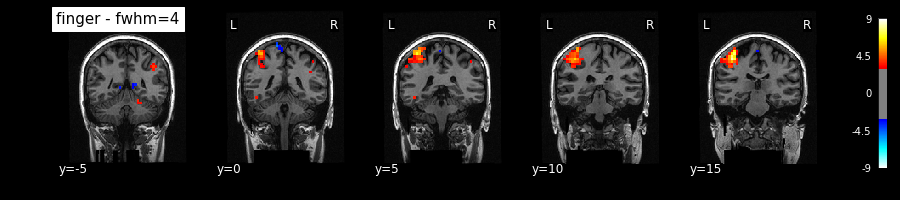

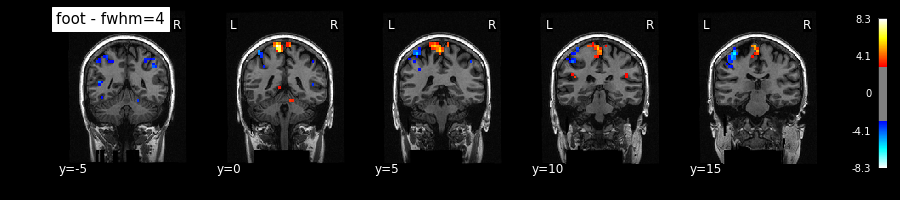

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

In [17]:
plot_stat_map(
    '/output/ds000114/1stLevel/sub-02/fwhm-4/spmT_0005.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-02/fwhm-4/spmT_0006.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-02/fwhm-4/spmT_0007.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)

## Special case

There is something special with the **Finger** contrast in all subjects. So let's take a look at all of them.

In [13]:
plot_stat_map(
    '/output/ds000114/1stLevel/sub-01/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-01',
    bg_img='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-02/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-02',
    bg_img='/data/ds000114/sub-02/ses-test/anat/sub-02_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-03/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-03',
    bg_img='/data/ds000114/sub-03/ses-test/anat/sub-03_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-04/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-04',
    bg_img='/data/ds000114/sub-04/ses-test/anat/sub-04_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-05/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-05',
    bg_img='/data/ds000114/sub-05/ses-test/anat/sub-05_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-06/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-06',
    bg_img='/data/ds000114/sub-06/ses-test/anat/sub-06_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-07/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-07',
    bg_img='/data/ds000114/sub-07/ses-test/anat/sub-07_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-08/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-08',
    bg_img='/data/ds000114/sub-08/ses-test/anat/sub-08_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-09/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-09',
    bg_img='/data/ds000114/sub-09/ses-test/anat/sub-09_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)
plot_stat_map(
    '/output/ds000114/1stLevel/sub-10/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-10',
    bg_img='/data/ds000114/sub-10/ses-test/anat/sub-10_ses-test_T1w.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1)


NameError: name 'plot_stat_map' is not defined

What you might see is that the hemisphere of the main cluster differs significantly between subjects. This is because all subjects were asked to use the dominant hand, either right or left. There were three subjects (``sub-01``, ``sub-06`` and ``sub-10``) that were left handed. This can be seen in the pictures above, where we find the main cluster in the left hemisphere for right handed subject and on the right hemisphere for left handed subjects.

**Because of this, We will use only right handed subjects for the following anlyses**.